### Python 3.8.10

In [23]:
!pip install -r requirements.txt
import numpy as np
import torch
from torchvision import transforms, datasets
from torchvision.utils import save_image

import unsplit.attacks as unsplit
from unsplit.models import *
from unsplit.util import *

import optimizers as opt

import scipy



  Using cached torch-1.7.1-cp38-cp38-manylinux1_x86_64.whl (776.8 MB)
ERROR: Could not find a version that satisfies the requirement scipy==1.12.0 (from -r requirements.txt (line 5)) (from versions: 0.8.0, 0.9.0, 0.10.0, 0.10.1, 0.11.0, 0.12.0, 0.12.1, 0.13.0, 0.13.1, 0.13.2, 0.13.3, 0.14.0, 0.14.1, 0.15.0, 0.15.1, 0.16.0, 0.16.1, 0.17.0, 0.17.1, 0.18.0, 0.18.1, 0.19.0, 0.19.1, 1.0.0, 1.0.1, 1.1.0, 1.2.0, 1.2.1, 1.2.2, 1.2.3, 1.3.0, 1.3.1, 1.3.2, 1.3.3, 1.4.0, 1.4.1, 1.5.0, 1.5.1, 1.5.2, 1.5.3, 1.5.4, 1.6.0, 1.6.1, 1.6.2, 1.6.3, 1.7.0, 1.7.1, 1.7.2, 1.7.3, 1.8.0rc1, 1.8.0rc2, 1.8.0rc3, 1.8.0rc4, 1.8.0, 1.8.1, 1.9.0rc1, 1.9.0rc2, 1.9.0rc3, 1.9.0, 1.9.1, 1.9.2, 1.9.3, 1.10.0rc1, 1.10.0rc2, 1.10.0, 1.10.1)
ERROR: No matching distribution found for scipy==1.12.0 (from -r requirements.txt (line 5))


In [24]:
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.device_count())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

True
0
1


device(type='cuda')

In [25]:
split_layer = 2

In [32]:
dataset = 'mnist'

if dataset == 'mnist':
    trainset = datasets.MNIST('data/mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.MNIST('data/mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'f_mnist':
    trainset = datasets.FashionMNIST('data/f_mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.FashionMNIST('data/f_mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'cifar':
    trainset = datasets.CIFAR10('data/cifar', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.CIFAR10('data/cifar', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = CifarNet(), CifarNet(), CifarNet()

trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, shuffle=True)

In [33]:
for images, labels in trainloader:
    for image in images:
        image = image.to(device)
    for label in labels:
        label = label.to(device)

## Learning without noise

In [28]:
client_opt = torch.optim.SGD(client.parameters(), lr=0.001)
server_opt = torch.optim.SGD(server.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

epochs = 50
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        client_opt.zero_grad()
        server_opt.zero_grad()

        pred = server(client(images, end=split_layer), start=split_layer+1)

        loss = criterion(pred, labels)
        loss.backward()
        running_loss += loss

        server_opt.step()
        client_opt.step()
    else:
        print(f'Epoch: {epoch} Loss: {running_loss / len(trainloader)} Acc: {get_test_score(client, server, testset, split=split_layer)}')

Epoch: 0 Loss: 2.302849531173706 Acc: 20.394736842105264
Epoch: 1 Loss: 2.3002285957336426 Acc: 16.294277929155314
Epoch: 2 Loss: 2.297558546066284 Acc: 17.40801757276222
Epoch: 3 Loss: 2.2943904399871826 Acc: 18.954248366013072
Epoch: 4 Loss: 2.2903969287872314 Acc: 25.583982202447164
Epoch: 5 Loss: 2.2847559452056885 Acc: 30.925013683634372
Epoch: 6 Loss: 2.2757861614227295 Acc: 33.49726775956284
Epoch: 7 Loss: 2.2591288089752197 Acc: 38.121245221190605
Epoch: 8 Loss: 2.222214460372925 Acc: 43.67816091954023
Epoch: 9 Loss: 2.120591878890991 Acc: 46.44420131291029
Epoch: 10 Loss: 1.7785375118255615 Acc: 69.07103825136612
Epoch: 11 Loss: 1.1191990375518799 Acc: 78.82611080636313
Epoch: 12 Loss: 0.6969941258430481 Acc: 83.04061470911087
Epoch: 13 Loss: 0.5477314591407776 Acc: 86.81440443213296
Epoch: 14 Loss: 0.4752420485019684 Acc: 87.4451754385965
Epoch: 15 Loss: 0.427045613527298 Acc: 88.21271929824562
Epoch: 16 Loss: 0.3906811773777008 Acc: 88.94362342638205
Epoch: 17 Loss: 0.361325

## Learning with noise

In [34]:
import torch.distributions as dist

class CustomNormalDistribution(nn.Module):
    def __init__(self, shape, mean, std):
        super(CustomNormalDistribution, self).__init__()
        self.shape = shape
        self.mean = nn.Parameter(torch.tensor(mean))
        self.std = nn.Parameter(torch.tensor(std))

    def forward(self):
        return dist.Normal(self.mean, self.std)


def noisybatch(images, mean=0.0, std=1.0):
    shape = images.shape
    custom_dist = CustomNormalDistribution(shape, mean, std)
    sample = custom_dist().rsample()
    return sample

Find global $l2$-sensitivity 

Now let us adjust distribution parameter $\sigma$ for $(\varepsilon, \delta)$-DP.

Code is taken from https://github.com/BorjaBalle/analytic-gaussian-mechanism/blob/master/agm-example.py

In [35]:
from math import exp, sqrt
from scipy.special import erf

def calibrateAnalyticGaussianMechanism(epsilon, delta, GS, tol = 1.e-12):
    """ Calibrate a Gaussian perturbation for differential privacy using the analytic Gaussian mechanism of [Balle and Wang, ICML'18]

    Arguments:
    epsilon : target epsilon (epsilon > 0)
    delta : target delta (0 < delta < 1)
    GS : upper bound on L2 global sensitivity (GS >= 0)
    tol : error tolerance for binary search (tol > 0)

    Output:
    sigma : standard deviation of Gaussian noise needed to achieve (epsilon,delta)-DP under global sensitivity GS
    """

    def Phi(t):
        return 0.5*(1.0 + erf(float(t)/sqrt(2.0)))

    def caseA(epsilon,s):
        return Phi(sqrt(epsilon*s)) - exp(epsilon)*Phi(-sqrt(epsilon*(s+2.0)))

    def caseB(epsilon,s):
        return Phi(-sqrt(epsilon*s)) - exp(epsilon)*Phi(-sqrt(epsilon*(s+2.0)))

    def doubling_trick(predicate_stop, s_inf, s_sup):
        while(not predicate_stop(s_sup)):
            s_inf = s_sup
            s_sup = 2.0*s_inf
        return s_inf, s_sup

    def binary_search(predicate_stop, predicate_left, s_inf, s_sup):
        s_mid = s_inf + (s_sup-s_inf)/2.0
        while(not predicate_stop(s_mid)):
            if (predicate_left(s_mid)):
                s_sup = s_mid
            else:
                s_inf = s_mid
            s_mid = s_inf + (s_sup-s_inf)/2.0
        return s_mid

    delta_thr = caseA(epsilon, 0.0)

    if (delta == delta_thr):
        alpha = 1.0

    else:
        if (delta > delta_thr):
            predicate_stop_DT = lambda s : caseA(epsilon, s) >= delta
            function_s_to_delta = lambda s : caseA(epsilon, s)
            predicate_left_BS = lambda s : function_s_to_delta(s) > delta
            function_s_to_alpha = lambda s : sqrt(1.0 + s/2.0) - sqrt(s/2.0)

        else:
            predicate_stop_DT = lambda s : caseB(epsilon, s) <= delta
            function_s_to_delta = lambda s : caseB(epsilon, s)
            predicate_left_BS = lambda s : function_s_to_delta(s) < delta
            function_s_to_alpha = lambda s : sqrt(1.0 + s/2.0) + sqrt(s/2.0)

        predicate_stop_BS = lambda s : abs(function_s_to_delta(s) - delta) <= tol

        s_inf, s_sup = doubling_trick(predicate_stop_DT, 0.0, 1.0)
        s_final = binary_search(predicate_stop_BS, predicate_left_BS, s_inf, s_sup)
        alpha = function_s_to_alpha(s_final)
        
    sigma = alpha*GS/sqrt(2.0*epsilon)

    return sigma

In [36]:
sigma = calibrateAnalyticGaussianMechanism(0.5, 0.5, 1.0)
sigma

0.5909175992591167

In [37]:
client_opt = torch.optim.SGD(client.parameters(), lr=0.001)
server_opt = torch.optim.SGD(server.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

epochs = 50
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        client_opt.zero_grad()
        server_opt.zero_grad()
        noise = noisybatch(images, mean=0.0, std=sigma)
        pred = server(client(torch.add(images, noise), end=split_layer), start=split_layer+1)

        loss = criterion(pred, labels)
        loss.backward()
        running_loss += loss

        server_opt.step()
        client_opt.step()
    else:
        print(f'Epoch: {epoch} Loss: {running_loss / len(trainloader)} Acc: {get_test_score(client, server, testset, split=split_layer)}')

Epoch: 0 Loss: 2.3013265132904053 Acc: 11.874656404617921
Epoch: 1 Loss: 2.2991409301757812 Acc: 9.96168582375479
Epoch: 2 Loss: 2.2969205379486084 Acc: 12.869660460021906
Epoch: 3 Loss: 2.294428586959839 Acc: 14.772103239978033
Epoch: 4 Loss: 2.291217565536499 Acc: 19.171270718232044
Epoch: 5 Loss: 2.2866628170013428 Acc: 20.95447065277016
Epoch: 6 Loss: 2.2795298099517822 Acc: 25.537782680639822
Epoch: 7 Loss: 2.268134593963623 Acc: 27.747252747252748
Epoch: 8 Loss: 2.247410774230957 Acc: 30.25164113785558
Epoch: 9 Loss: 2.20170521736145 Acc: 32.273972602739725
Epoch: 10 Loss: 2.085899829864502 Acc: 39.533622559652926
Epoch: 11 Loss: 1.8269679546356201 Acc: 53.300600109110746
Epoch: 12 Loss: 1.46431303024292 Acc: 66.29773104593248
Epoch: 13 Loss: 1.079716682434082 Acc: 75.1937984496124
Epoch: 14 Loss: 0.8271255493164062 Acc: 81.68316831683168
Epoch: 15 Loss: 0.6826847791671753 Acc: 84.73282442748092
Epoch: 16 Loss: 0.5860381126403809 Acc: 86.57047724750278
Epoch: 17 Loss: 0.523385822

Now let us see how adding noise affects on attacks.

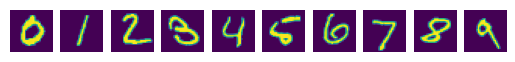

In [38]:
COUNT = 1

inversion_targets = [get_examples_by_class(testset, c, count=COUNT) for c in range(10)]
targetloader = torch.utils.data.DataLoader(inversion_targets, shuffle=False)
mse = torch.nn.MSELoss()

display_imagelist(inversion_targets, 28, 28)

Without noise:

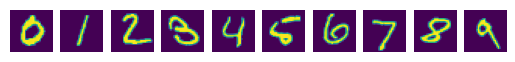

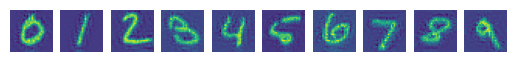

In [31]:
results, losses = [], []
for idx, target in enumerate(targetloader):
    # obtain client output
    client_out = client(target, end=split_layer)

    # perform the attack
    result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=1000, input_iters=100, model_iters=100)

    # save result
    if dataset == 'cifar':
        result = normalize(result)
    results.append(result)
    loss = mse(result, target)
    losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28)
    display_imagelist(results, 28, 28)

With noise:

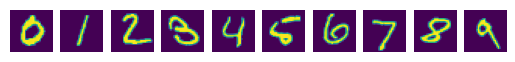

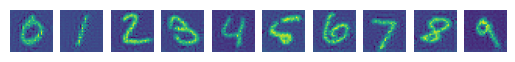

In [39]:
results, losses = [], []
for idx, target in enumerate(targetloader):
    # obtain client output
    client_out = client(target, end=split_layer)

    # perform the attack
    result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=1000, input_iters=100, model_iters=100)

    # save result
    if dataset == 'cifar':
        result = normalize(result)
    results.append(result)
    loss = mse(result, target)
    losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28)
    display_imagelist(results, 28, 28)